In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
DATA_ROOT = "/scratch/attiqrehman/data/train"
DATA_ROOT_TEST = "/scratch/attiqrehman/data/test"

In [3]:
transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((256,256))
    ])

In [4]:
dataset = torchvision.datasets.ImageFolder(DATA_ROOT, transforms)
dataset_test = torchvision.datasets.ImageFolder(DATA_ROOT_TEST, transforms)

In [5]:
class_names = dataset.classes

In [6]:
dataset_sizes = {'train': 42317, 'val': 10580, 'test': 5863}
train_set, val_set = torch.utils.data.random_split(dataset, [dataset_sizes['train'], dataset_sizes['val']])

dataloaders = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=4),
}


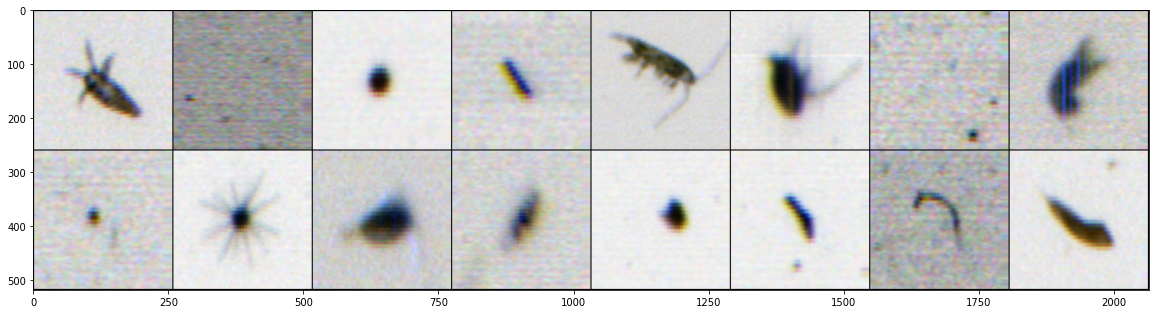

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(20, 20))
imshow(out, title=[dataset.classes[x] for x in classes])

In [8]:
len(inputs[1][1][1])

256

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}/{}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = torchvision.models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = torch.nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1789 Acc: 0.9323
val Loss: 0.1140 Acc: 0.9569

Epoch 1/4
----------
train Loss: 0.0924 Acc: 0.9652
val Loss: 0.0943 Acc: 0.9636

Epoch 2/4
----------
train Loss: 0.0611 Acc: 0.9768
val Loss: 0.1008 Acc: 0.9643

Epoch 3/4
----------
train Loss: 0.0433 Acc: 0.9843
val Loss: 0.0910 Acc: 0.9672

Epoch 4/4
----------
train Loss: 0.0315 Acc: 0.9885
val Loss: 0.0949 Acc: 0.9692

Training complete in 35m 44s
Best val Acc: 0.969187


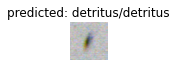

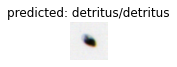

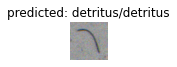

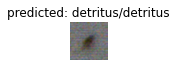

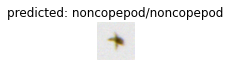

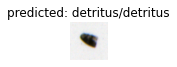

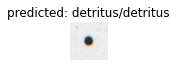

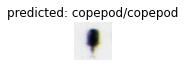

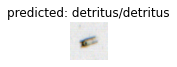

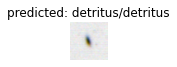

In [14]:
visualize_model(model_ft,10)

In [15]:
def evaluate(model,dataloader,dataset_size):
    since = time.time()
    
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_size
    test_acc = running_corrects.double() / dataset_size

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(
         test_loss, test_acc))


In [16]:
evaluate(model_ft, dataloaders['test'], dataset_sizes['test'])


Training complete in 0m 10s
Test Loss: 0.0932 Acc: 0.9729


In [30]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.double())

tensor([[ 994.,   13.,   23.],
        [  12., 3968.,   20.],
        [  66.,   25.,  742.]], dtype=torch.float64)


In [41]:
from numpy import savetxt
savetxt('/output/models/torch_resnet50_label2_rawdata_cm.csv', confusion_matrix.numpy(), delimiter=',')

In [33]:
print(confusion_matrix.numpy())

[[ 994.   13.   23.]
 [  12. 3968.   20.]
 [  66.   25.  742.]]


In [18]:
torch.set_printoptions(sci_mode=False)
print(confusion_matrix.tolist())

[[994.0, 13.0, 23.0], [12.0, 3968.0, 20.0], [66.0, 25.0, 742.0]]


In [19]:
classes

tensor([0, 1, 1, 1, 1, 0, 1], device='cuda:0')

In [20]:
preds

tensor([0, 1, 1, 1, 1, 0, 1], device='cuda:0')

Accuracy assessment - Compute precision, recall, f1 and accuracy

In [45]:
def evaluate(confusion_matrix, classes):
    true_pos = np.diag(confusion_matrix)
    false_pos = np.sum(confusion_matrix, axis=0) - true_pos
    false_neg = np.sum(confusion_matrix, axis=1) - true_pos

    accuracy = sum(true_pos) / np.sum(confusion_matrix)
    precision = (true_pos / (true_pos + false_pos))
    recall = (true_pos / (true_pos + false_neg))
    f1 = 2*precision*recall / (precision + recall)

    precision = np.mean(precision)
    recall = np.mean(recall)

    f1 = np.mean(f1)
    return precision, recall, accuracy, f1

In [46]:
evaluate(confusion_matrix.numpy(), 3)

(0.95432526, 0.9492683, 0.9728807777588265, 0.9514014)

In [ ]:
import seaborn as sn
import pandas as pd

In [ ]:
df_cm = pd.DataFrame(confusion_matrix.numpy().astype(np.int32), index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g') # font size



In [42]:
torch.save(model_ft.state_dict(), "/output/models/torch_resnet50_label2_rawdata.pth")

In [ ]:
! pwd